1. Load the Required Libraries

In [21]:
import pandas as pd
import numpy as np
import dtale
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs()
from imblearn.over_sampling import SMOTE
import category_encoders as ce
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score,recall_score

C:\Users\Frank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



2. Read the data from the dataset

Dataset shape: (100000, 9)

Data types:
 gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

Missing values:
 gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


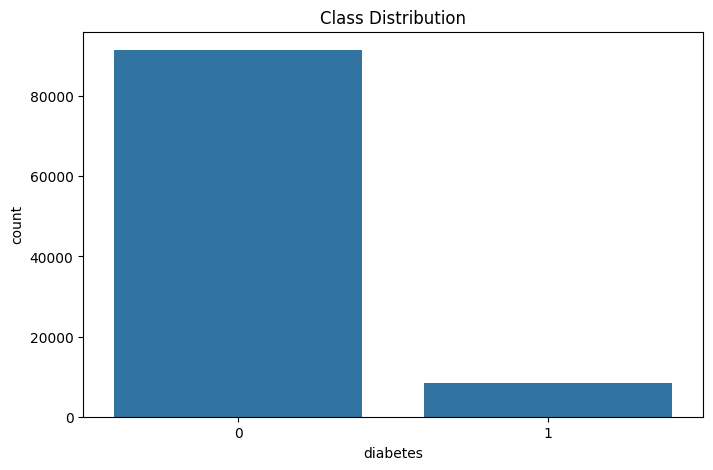

In [ ]:
df = pd.read_csv("../../Datasets/diabetes_prediction_dataset.csv", encoding='latin1')
print(f"Dataset shape: {df.shape}")
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# Visualize class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='diabetes', data=df)
plt.title('Class Distribution')
plt.show()

3. Handling missing values and replacing missing values with nan from numpy and replace with mean of all the other values

In [3]:
print(df.isnull().sum())
print(df.isna().sum())
dtale.show(df)

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


4. Encoding categorical values

In [4]:
gender_mapping = {'Female': 0, 'Male': 1, 'Other': 2}
df['gender'] = df['gender'].map(gender_mapping)
dtale.show(df)

In [5]:
smoking_mapping = {'never': 0, 'not current': 1, 'current': 2, 
                  'No Info': 3, 'ever': 4, 'former': 5}
df['smoking_history'] = df['smoking_history'].map(smoking_mapping)
dtale.show(df)

5. Feature Engineering

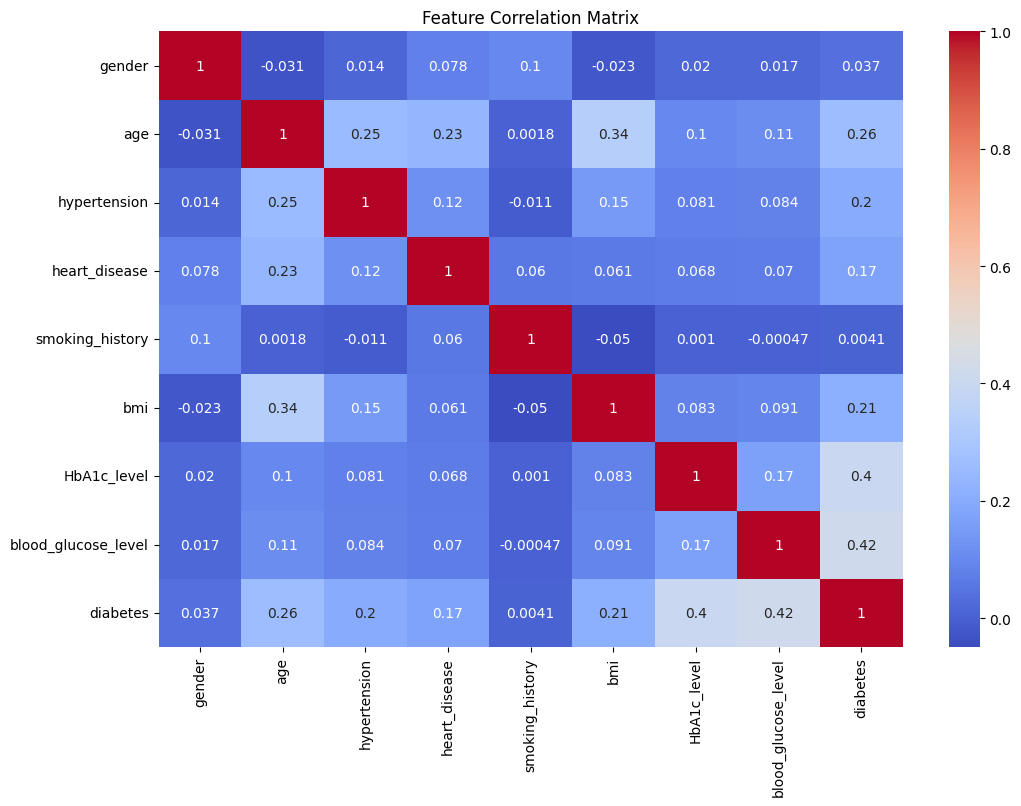

In [6]:
# Add feature correlation analysis
plt.figure(figsize=(12,8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

6. Split the attribites into dependent and independent attributes

In [7]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
dtale.show(Y, ignore_duplicate=True)

7. Splitting the dataset intro training set and test set

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

7. Train the Random Forest Model

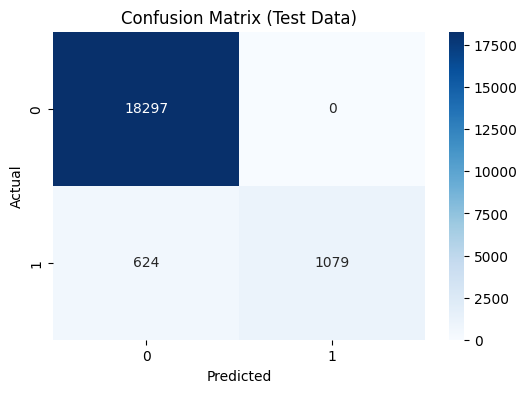

              precision    recall  f1-score     support
0              0.967021  1.000000  0.983234  18297.0000
1              1.000000  0.633588  0.775701   1703.0000
accuracy       0.968800  0.968800  0.968800      0.9688
macro avg      0.983510  0.816794  0.879467  20000.0000
weighted avg   0.969829  0.968800  0.965562  20000.0000


In [12]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf.fit(X_train, Y_train)
y_pred_train = rf.predict(X_test)
cm_train = confusion_matrix(Y_test, y_pred_train)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Data)')
plt.show()

# Display evaluation matrix (classification report)
report_train = classification_report(Y_test, y_pred_train, output_dict=True)
df_report_train = pd.DataFrame(report_train).transpose()
print(df_report_train)

In [14]:
rfparams = {
    
    'n_estimators': 1000,
    'criterion': 'entropy',
    'min_samples_split': 10,
    'random_state':42}

8. Retraining the model using Resampled data

In [15]:
smote_enn = SMOTE(sampling_strategy='minority', random_state=42)
X_train_res, Y_train_res = smote_enn.fit_resample(X_train, Y_train)
print(pd.Series(Y_train_res).value_counts())

diabetes
0    73203
1    73203
Name: count, dtype: int64


In [16]:
model = RandomForestClassifier(**rfparams)
model.fit(X_train_res, Y_train_res) 
Kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_res, Y_train_res, cv=Kfold, scoring='accuracy')

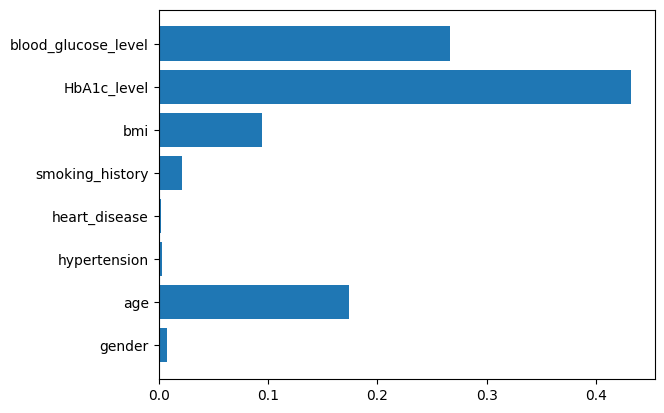

In [17]:
importances = model.feature_importances_
features = df.columns[:-1]
plt.barh(features, importances)
plt.show()

10. Evaluate the retrained model

In [18]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
sensitivity = recall_score(Y_test, y_pred, pos_label=1)
roc_auc = roc_auc_score(Y_test, y_proba)

tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
specificity = tn / (tn + fp)

report = classification_report(Y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

pd.set_option("display.precision", 4)
print(df_report)
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test, y_pred)}")
print(f"Mean Accuracy:{scores.mean():.4f} (+/- {scores.std():.4f})")

              precision  recall  f1-score     support
0                0.9764  0.9752    0.9758  18297.0000
1                0.7370  0.7469    0.7419   1703.0000
accuracy         0.9557  0.9557    0.9557      0.9557
macro avg        0.8567  0.8611    0.8589  20000.0000
weighted avg     0.9560  0.9557    0.9559  20000.0000
ROC-AUC: 0.9705
Sensitivity: 0.7469
Specificity: 0.9752
Confusion Matrix:
[[17843   454]
 [  431  1272]]
Mean Accuracy:0.9731 (+/- 0.0013)


11.Feature Importance Visualization

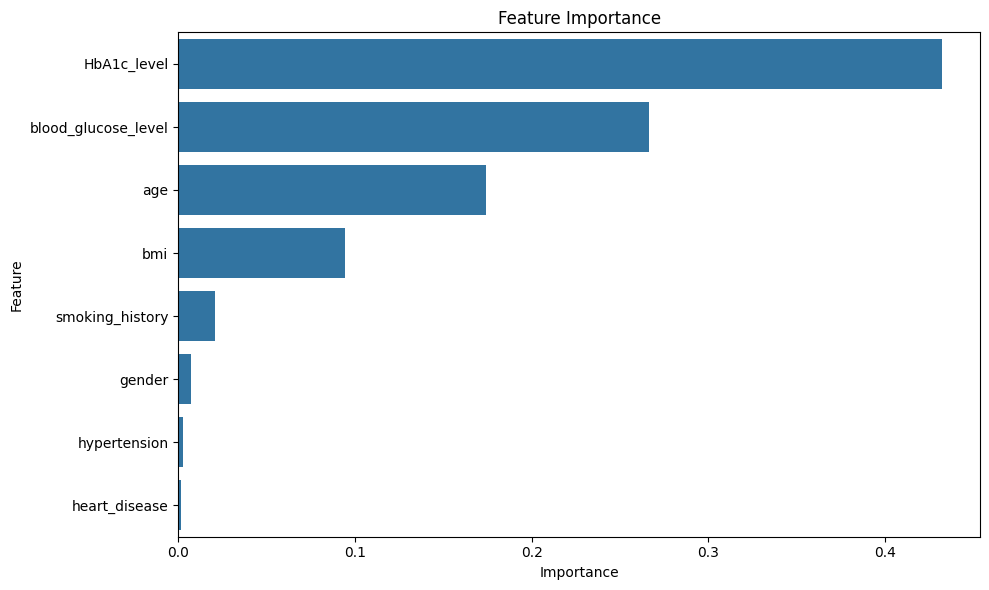

In [19]:
# Feature importance analysis
importance = model.feature_importances_
features = df.columns[:-1]

# Create DataFrame and sort
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

12. Apply Shapley Additive Technique to the data

In [ ]:
#get the SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_train_res)
print(shap_values.shape)

In [ ]:
#Waterfall plot for the first observation
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.summary_plot(shap_values, X_train_res)